In [1]:
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import gaussian_kde

sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.verification import load_tganom_and_compute, load_tgex_and_compute, build_fit_nn_model, compute_bss, compute_kss, compute_auc, reduce_to_ranks, reduce_to_skill

sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.utils import reliability_plot

2022-01-11 17:05:37.013353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-11 17:05:37.013375: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Investigation of most successful prediction
(When going through the standard objective predictor selection).

In [2]:
name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15'
total, test_only = build_fit_nn_model(predictandname = name, npreds = 4, use_jmeasure=False)
trainval_only = total.drop(test_only.index, axis = 0)

fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200


2022-01-11 17:05:40.927006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-11 17:05:40.927040: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-11 17:05:40.927065: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc160104): /proc/driver/nvidia/version does not exist
2022-01-11 17:05:40.927264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-11 17:05:40.978571: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optim

41/41 [==============================] - 0s 4ms/step - loss: 0.7260 - accuracy: 0.5498 - brier: 0.2597 - val_loss: 0.7860 - val_accuracy: 0.4826 - val_brier: 0.2891
Epoch 2/200
41/41 [==============================] - 0s 997us/step - loss: 0.7235 - accuracy: 0.5498 - brier: 0.2584 - val_loss: 0.7838 - val_accuracy: 0.4826 - val_brier: 0.2883
Epoch 3/200
41/41 [==============================] - 0s 999us/step - loss: 0.7196 - accuracy: 0.5653 - brier: 0.2565 - val_loss: 0.7804 - val_accuracy: 0.4826 - val_brier: 0.2870
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7123 - accuracy: 0.5793 - brier: 0.2532 - val_loss: 0.7752 - val_accuracy: 0.4905 - val_brier: 0.2848
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7018 - accuracy: 0.5793 - brier: 0.2485 - val_loss: 0.7684 - val_accuracy: 0.4968 - val_brier: 0.2819
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6879 - accuracy: 0.5972 - brier: 0.2419 - val_lo

41/41 [==============================] - 0s 1ms/step - loss: 0.5331 - accuracy: 0.7589 - brier: 0.1705 - val_loss: 0.6244 - val_accuracy: 0.6356 - val_brier: 0.2191
Epoch 48/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5319 - accuracy: 0.7621 - brier: 0.1697 - val_loss: 0.6212 - val_accuracy: 0.6341 - val_brier: 0.2181
Epoch 49/200
41/41 [==============================] - 0s 996us/step - loss: 0.5316 - accuracy: 0.7628 - brier: 0.1697 - val_loss: 0.6214 - val_accuracy: 0.6341 - val_brier: 0.2181
Epoch 50/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5320 - accuracy: 0.7566 - brier: 0.1699 - val_loss: 0.6216 - val_accuracy: 0.6341 - val_brier: 0.2182
Epoch 51/200
41/41 [==============================] - 0s 991us/step - loss: 0.5319 - accuracy: 0.7589 - brier: 0.1697 - val_loss: 0.6237 - val_accuracy: 0.6341 - val_brier: 0.2186
Epoch 52/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5317 - accuracy: 0.7613 - brier: 0.1696 - v

In [3]:
n_iter = 2000
bs = pd.DataFrame(np.nan, columns = pd.MultiIndex.from_product([['trainval','test'],test_only.columns[test_only.columns.str.endswith('_bs')]], names = ['set','forecast']), index = pd.RangeIndex(n_iter))
for i in range(n_iter):

    trainval_sample = np.random.randint(low = 0, high = trainval_only.shape[0], size = trainval_only.shape[0]) # bootstrap sample with replacement.
    test_sample = np.random.randint(low = 0, high = test_only.shape[0], size = test_only.shape[0])
    
    for forecast_key in bs.columns.get_level_values('forecast').unique():
        bs.loc[i,('test',forecast_key)] = test_only[forecast_key].iloc[test_sample.tolist()].mean()
        bs.loc[i,('trainval',forecast_key)] = trainval_only[forecast_key].iloc[trainval_sample.tolist()].mean()

In [4]:
bs.columns

MultiIndex([('trainval',          'pi_bs'),
            ('trainval',        'ppsf_bs'),
            ('trainval', 'climatology_bs'),
            ('trainval',       'trend_bs'),
            (    'test',          'pi_bs'),
            (    'test',        'ppsf_bs'),
            (    'test', 'climatology_bs'),
            (    'test',       'trend_bs')],
           names=['set', 'forecast'])

In [5]:
# scale test and trainval BS separately based on the mean raw score
bszero = bs.copy()
bszero['test'] = bs['test'] - float(bs[('test', 'pi_bs')].mean())
bszero['trainval'] = bs['trainval'] - float(bs[('trainval', 'pi_bs')].mean())

In [6]:
def to_kernel_density(vals):
    if isinstance(vals, (pd.Series, pd.DataFrame)):
        vals = vals.values.squeeze()
    positions = np.linspace(start = vals.min(), stop = vals.max(), num = 100)
    density = gaussian_kde(vals)(positions)
    return(positions, density)

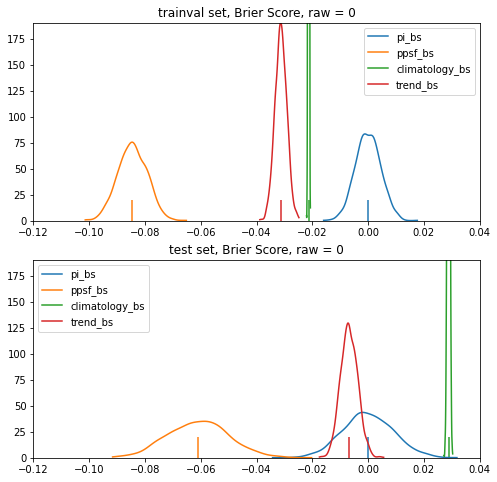

In [7]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (8,8), squeeze = False)
for key in bszero.columns:
    i = bszero.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    im = ax.plot(*to_kernel_density(bszero[key]),label = key[-1])
    ax.vlines(x = float(bszero[key].mean()), ymin=0, ymax = 20, color = im[0].get_c())
    ax.set_xlim(left = -0.12, right = 0.04)
    ax.set_ylim(0,190)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

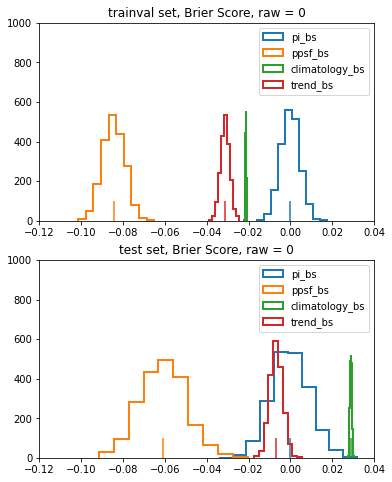

In [15]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (6,8), squeeze = False)
for key in bszero.columns:
    i = bszero.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    im = ax.hist(bszero[key], label = key[-1], histtype = 'step', lw = 2)
    ax.vlines(x = float(bszero[key].mean()), ymin=0, ymax = 100, color = im[2][0].get_edgecolor())
    #ax.set_xlim(left = -0.12, right = 0.08)
    ax.set_xlim(left = -0.12, right = 0.04)
    ax.set_ylim(0,1000)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

In [9]:
test_only.columns.name = 'type'
trainval_only.columns.name = 'type'

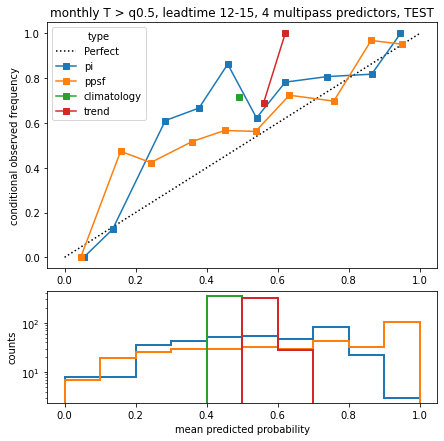

In [14]:
fig, (axrel, axhist) = reliability_plot(y_true = test_only['observation'], y_probs=test_only[['pi', 'ppsf', 'climatology','trend']])
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TEST')
plt.show()

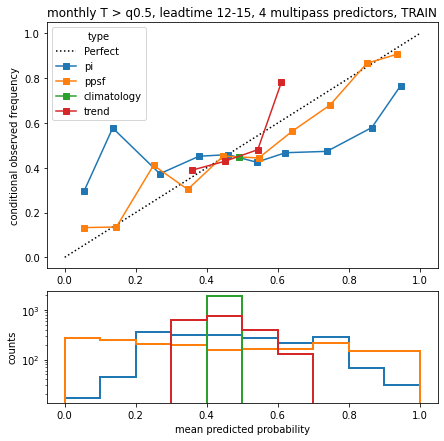

In [13]:
fig, (axrel, axhist) = reliability_plot(y_true = trainval_only['observation'], y_probs=trainval_only[['pi', 'ppsf', 'climatology','trend']])
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TRAIN')
plt.show()

## Broad verification
Multiple metrics, thresholds, time scales, lead times. Currently post-processed combinations are not post-processed with jmeasure input.

In [2]:
def extra_scores_and_rank(df):
    compute_kss(df)
    compute_auc(df)
    return reduce_to_skill(df)

In [3]:
# Handle all the tganom post-processed combinations with objective sequential forward predictors.
# We will only look at test data.
timeaggs = [21,31]
quantiles = [0.5, 0.66, 0.75, 0.9]
npreds = pd.Series([4,3,4,6,4,4,4,12], index = pd.MultiIndex.from_product([timeaggs, quantiles], names = ['timeagg','quantile'])) # This is a mixture of >3% >4%
def get_tganom_predictions(timeagg: int, quantile: float):
    name = f'tg-anom_JJA_45r1_{timeagg}D-roll-mean_q{quantile}_sep12-15'
    _, test_only = build_fit_nn_model(predictandname = name, npreds = npreds.loc[(timeagg,quantile)], use_jmeasure=False)
    return test_only
results = []
for timeagg, quantile in npreds.index:
    results.append(extra_scores_and_rank(get_tganom_predictions(timeagg, quantile)))
ranktganom = pd.concat(results, axis = 1, keys = npreds.index).T

fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200


2022-01-10 14:48:01.193050: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-10 14:48:01.193083: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-10 14:48:01.193108: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc160104): /proc/driver/nvidia/version does not exist
2022-01-10 14:48:01.193355: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-10 14:48:01.245223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optim

41/41 [==============================] - 0s 4ms/step - loss: 0.7086 - accuracy: 0.5832 - brier: 0.2523 - val_loss: 0.7517 - val_accuracy: 0.5110 - val_brier: 0.2743
Epoch 2/200
41/41 [==============================] - 0s 991us/step - loss: 0.7064 - accuracy: 0.5832 - brier: 0.2512 - val_loss: 0.7493 - val_accuracy: 0.5110 - val_brier: 0.2733
Epoch 3/200
41/41 [==============================] - 0s 992us/step - loss: 0.7031 - accuracy: 0.5832 - brier: 0.2498 - val_loss: 0.7448 - val_accuracy: 0.5110 - val_brier: 0.2715
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6976 - accuracy: 0.5925 - brier: 0.2474 - val_loss: 0.7375 - val_accuracy: 0.5205 - val_brier: 0.2686
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6894 - accuracy: 0.6042 - brier: 0.2440 - val_loss: 0.7278 - val_accuracy: 0.5315 - val_brier: 0.2646
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6790 - accuracy: 0.6174 - brier: 0.2395 - val_lo

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.5810 - accuracy: 0.7208 - brier: 0.1935 - val_loss: 0.7001 - val_accuracy: 0.6293 - val_brier: 0.2448
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5688 - accuracy: 0.7348 - brier: 0.1892 - val_loss: 0.6895 - val_accuracy: 0.6435 - val_brier: 0.2399
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5529 - accuracy: 0.7457 - brier: 0.1814 - val_loss: 0.6711 - val_accuracy: 0.6372 - val_brier: 0.2330
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5367 - accuracy: 0.7597 - brier: 0.1750 - val_loss: 0.6595 - val_accuracy: 0.6767 - val_brier: 0.2266
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5243 - accuracy: 0.7644 - brier: 0.1692 - val_loss: 0.6416 - val_accuracy: 0.6735 - val_brier: 0.2202
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5140 - accuracy: 0.7768 - brier: 0.1644 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.4505 - accuracy: 0.8126 - brier: 0.1423 - val_loss: 0.6144 - val_accuracy: 0.7256 - val_brier: 0.2011
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4239 - accuracy: 0.8235 - brier: 0.1328 - val_loss: 0.5907 - val_accuracy: 0.7429 - val_brier: 0.1958
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3941 - accuracy: 0.8359 - brier: 0.1217 - val_loss: 0.5657 - val_accuracy: 0.7492 - val_brier: 0.1856
Epoch 4/200
41/41 [==============================] - 0s 993us/step - loss: 0.3657 - accuracy: 0.8398 - brier: 0.1113 - val_loss: 0.5492 - val_accuracy: 0.7571 - val_brier: 0.1802
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3461 - accuracy: 0.8515 - brier: 0.1041 - val_loss: 0.5429 - val_accuracy: 0.7587 - val_brier: 0.1774
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3324 - accuracy: 0.8569 - brier: 0.0993 - val_loss

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.2615 - accuracy: 0.9184 - brier: 0.0708 - val_loss: 0.2916 - val_accuracy: 0.9180 - val_brier: 0.0751
Epoch 2/200
41/41 [==============================] - 0s 993us/step - loss: 0.2540 - accuracy: 0.9207 - brier: 0.0691 - val_loss: 0.2902 - val_accuracy: 0.9164 - val_brier: 0.0748
Epoch 3/200
41/41 [==============================] - 0s 999us/step - loss: 0.2428 - accuracy: 0.9215 - brier: 0.0665 - val_loss: 0.2878 - val_accuracy: 0.9196 - val_brier: 0.0743
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2293 - accuracy: 0.9191 - brier: 0.0635 - val_loss: 0.2806 - val_accuracy: 0.9227 - val_brier: 0.0718
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2169 - accuracy: 0.9222 - brier: 0.0600 - val_loss: 0.2735 - val_accuracy: 0.9196 - val_brier: 0.0691
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2057 - accuracy: 0.9222 - brier: 0.0578 - val_lo

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.7212 - accuracy: 0.5677 - brier: 0.2572 - val_loss: 0.7764 - val_accuracy: 0.4874 - val_brier: 0.2853
Epoch 2/200
41/41 [==============================] - 0s 988us/step - loss: 0.6856 - accuracy: 0.6073 - brier: 0.2408 - val_loss: 0.7463 - val_accuracy: 0.5205 - val_brier: 0.2725
Epoch 3/200
41/41 [==============================] - 0s 987us/step - loss: 0.6325 - accuracy: 0.6703 - brier: 0.2161 - val_loss: 0.7130 - val_accuracy: 0.5315 - val_brier: 0.2580
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5961 - accuracy: 0.7076 - brier: 0.1994 - val_loss: 0.6927 - val_accuracy: 0.5694 - val_brier: 0.2495
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5775 - accuracy: 0.7224 - brier: 0.1904 - val_loss: 0.6751 - val_accuracy: 0.5852 - val_brier: 0.2421
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5640 - accuracy: 0.7325 - brier: 0.1846 - val_lo

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.5509 - accuracy: 0.7473 - brier: 0.1813 - val_loss: 0.7223 - val_accuracy: 0.6483 - val_brier: 0.2478
Epoch 2/200
41/41 [==============================] - 0s 999us/step - loss: 0.5217 - accuracy: 0.7543 - brier: 0.1706 - val_loss: 0.7056 - val_accuracy: 0.6751 - val_brier: 0.2383
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4963 - accuracy: 0.7652 - brier: 0.1612 - val_loss: 0.6879 - val_accuracy: 0.6909 - val_brier: 0.2309
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4766 - accuracy: 0.7768 - brier: 0.1543 - val_loss: 0.6660 - val_accuracy: 0.6767 - val_brier: 0.2248
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4637 - accuracy: 0.7908 - brier: 0.1495 - val_loss: 0.6560 - val_accuracy: 0.6909 - val_brier: 0.2194
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4515 - accuracy: 0.7994 - brier: 0.1453 - val_loss

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.4267 - accuracy: 0.8320 - brier: 0.1317 - val_loss: 0.6252 - val_accuracy: 0.7319 - val_brier: 0.1987
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4113 - accuracy: 0.8390 - brier: 0.1265 - val_loss: 0.6036 - val_accuracy: 0.7603 - val_brier: 0.1925
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3877 - accuracy: 0.8507 - brier: 0.1179 - val_loss: 0.5722 - val_accuracy: 0.7776 - val_brier: 0.1823
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3598 - accuracy: 0.8631 - brier: 0.1079 - val_loss: 0.5529 - val_accuracy: 0.7729 - val_brier: 0.1738
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3401 - accuracy: 0.8764 - brier: 0.1011 - val_loss: 0.5315 - val_accuracy: 0.7902 - val_brier: 0.1662
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3254 - accuracy: 0.8802 - brier: 0.0963 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.2563 - accuracy: 0.9238 - brier: 0.0683 - val_loss: 0.3195 - val_accuracy: 0.8959 - val_brier: 0.0875
Epoch 2/200
41/41 [==============================] - 0s 997us/step - loss: 0.2435 - accuracy: 0.9238 - brier: 0.0657 - val_loss: 0.3135 - val_accuracy: 0.8959 - val_brier: 0.0855
Epoch 3/200
41/41 [==============================] - 0s 995us/step - loss: 0.2219 - accuracy: 0.9222 - brier: 0.0598 - val_loss: 0.3192 - val_accuracy: 0.8927 - val_brier: 0.0865
Epoch 4/200
41/41 [==============================] - 0s 991us/step - loss: 0.1994 - accuracy: 0.9316 - brier: 0.0539 - val_loss: 0.3054 - val_accuracy: 0.8975 - val_brier: 0.0827
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.1821 - accuracy: 0.9355 - brier: 0.0497 - val_loss: 0.2972 - val_accuracy: 0.9006 - val_brier: 0.0800
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.1660 - accuracy: 0.9432 - brier: 0.0445 - val_

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


In [4]:
# Handle the tg-ex postprocessed. Test_only.
ndaythresh = [5,7,9,11]
npreds = pd.Series([6,8,11,8], index = pd.Index(ndaythresh, name = 'nday_threshold'))
results = []
for th in ndaythresh:
    name = f'tg-ex-q0.75-21D_ge{th}D_sep12-15'
    _, test_only = build_fit_nn_model(predictandname = name, npreds = npreds.loc[th], use_jmeasure=False)
    results.append(extra_scores_and_rank(test_only))
ranktgex = pd.concat(results, axis = 1, keys = npreds.index).T

fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200
41/41 [==============================] - 0s 3ms/step - loss: 0.7332 - accuracy: 0.5373 - brier: 0.2638 - val_loss: 0.7932 - val_accuracy: 0.4495 - val_brier: 0.2900
Epoch 2/200
41/41 [==============================] - 0s 998us/step - loss: 0.7101 - accuracy: 0.5568 - brier: 0.2537 - val_loss: 0.7807 - val_accuracy: 0.5000 - val_brier: 0.2837
Epoch 3/200
41/41 [==============================] - 0s 991us/step - loss: 0.6737 - accuracy: 0.6011 - brier: 0.2373 - val_loss: 0.6893 - val_accuracy: 0.5678 - val_brier: 0.2451
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6463 - accuracy: 0.6345 - brier: 0.2245 - val_loss: 0.6490 - val_accuracy: 0.6120 - val_brier: 0.2275
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6282 - accuracy: 0.6540 - brier: 0.2168 - val_loss: 0.6399 - val_accuracy: 0.6278 - val_brier: 0.2233
Epoch 6/200
41/41 [=============================

Epoch 47/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5178 - accuracy: 0.7667 - brier: 0.1677 - val_loss: 0.4820 - val_accuracy: 0.7823 - val_brier: 0.1558
Epoch 48/200
41/41 [==============================] - 0s 997us/step - loss: 0.5166 - accuracy: 0.7652 - brier: 0.1674 - val_loss: 0.4754 - val_accuracy: 0.7871 - val_brier: 0.1534
Epoch 49/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5171 - accuracy: 0.7605 - brier: 0.1671 - val_loss: 0.5052 - val_accuracy: 0.7808 - val_brier: 0.1642
Epoch 50/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5158 - accuracy: 0.7636 - brier: 0.1671 - val_loss: 0.4902 - val_accuracy: 0.7902 - val_brier: 0.1588
Epoch 51/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5173 - accuracy: 0.7683 - brier: 0.1679 - val_loss: 0.4787 - val_accuracy: 0.7886 - val_brier: 0.1547
Epoch 52/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5163 - accuracy: 0.7659 - brier:

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.5595 - accuracy: 0.7302 - brier: 0.1870 - val_loss: 0.6686 - val_accuracy: 0.6735 - val_brier: 0.2280
Epoch 2/200
41/41 [==============================] - 0s 982us/step - loss: 0.5251 - accuracy: 0.7582 - brier: 0.1733 - val_loss: 0.6218 - val_accuracy: 0.7019 - val_brier: 0.2097
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4730 - accuracy: 0.7924 - brier: 0.1528 - val_loss: 0.5728 - val_accuracy: 0.7524 - val_brier: 0.1907
Epoch 4/200
41/41 [==============================] - 0s 993us/step - loss: 0.4316 - accuracy: 0.7947 - brier: 0.1368 - val_loss: 0.5387 - val_accuracy: 0.7666 - val_brier: 0.1767
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4048 - accuracy: 0.8157 - brier: 0.1267 - val_loss: 0.5193 - val_accuracy: 0.7681 - val_brier: 0.1685
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3900 - accuracy: 0.8196 - brier: 0.1217 - val_lo

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.4287 - accuracy: 0.8274 - brier: 0.1339 - val_loss: 0.5173 - val_accuracy: 0.7965 - val_brier: 0.1598
Epoch 2/200
41/41 [==============================] - 0s 994us/step - loss: 0.4038 - accuracy: 0.8313 - brier: 0.1256 - val_loss: 0.4786 - val_accuracy: 0.8297 - val_brier: 0.1440
Epoch 3/200
41/41 [==============================] - 0s 995us/step - loss: 0.3624 - accuracy: 0.8453 - brier: 0.1116 - val_loss: 0.4524 - val_accuracy: 0.8328 - val_brier: 0.1384
Epoch 4/200
41/41 [==============================] - 0s 992us/step - loss: 0.3236 - accuracy: 0.8561 - brier: 0.0980 - val_loss: 0.4138 - val_accuracy: 0.8533 - val_brier: 0.1246
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2954 - accuracy: 0.8756 - brier: 0.0877 - val_loss: 0.3891 - val_accuracy: 0.8596 - val_brier: 0.1169
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2741 - accuracy: 0.8904 - brier: 0.0810 - val_

41/41 [==============================] - 0s 1ms/step - loss: 0.1582 - accuracy: 0.9300 - brier: 0.0483 - val_loss: 0.2163 - val_accuracy: 0.9054 - val_brier: 0.0621
Epoch 94/200
41/41 [==============================] - 0s 1ms/step - loss: 0.1546 - accuracy: 0.9308 - brier: 0.0472 - val_loss: 0.2122 - val_accuracy: 0.9069 - val_brier: 0.0605
Epoch 95/200
41/41 [==============================] - 0s 1ms/step - loss: 0.1546 - accuracy: 0.9300 - brier: 0.0471 - val_loss: 0.2121 - val_accuracy: 0.9069 - val_brier: 0.0605
Epoch 96/200
41/41 [==============================] - 0s 1ms/step - loss: 0.1540 - accuracy: 0.9316 - brier: 0.0469 - val_loss: 0.2087 - val_accuracy: 0.9227 - val_brier: 0.0590
Epoch 97/200
41/41 [==============================] - 0s 1ms/step - loss: 0.1539 - accuracy: 0.9285 - brier: 0.0471 - val_loss: 0.2120 - val_accuracy: 0.9069 - val_brier: 0.0605
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
excluding test years [2013 2015 2016 20

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.3056 - accuracy: 0.8950 - brier: 0.0872 - val_loss: 0.3536 - val_accuracy: 0.9038 - val_brier: 0.0932
Epoch 2/200
41/41 [==============================] - 0s 991us/step - loss: 0.2950 - accuracy: 0.8950 - brier: 0.0839 - val_loss: 0.3520 - val_accuracy: 0.9069 - val_brier: 0.0935
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2852 - accuracy: 0.8966 - brier: 0.0813 - val_loss: 0.3540 - val_accuracy: 0.9022 - val_brier: 0.0961
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2707 - accuracy: 0.9012 - brier: 0.0770 - val_loss: 0.3368 - val_accuracy: 0.9085 - val_brier: 0.0902
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2566 - accuracy: 0.9044 - brier: 0.0736 - val_loss: 0.3362 - val_accuracy: 0.9117 - val_brier: 0.0916
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2420 - accuracy: 0.9082 - brier: 0.0687 - val_loss

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


In [5]:
# Handle the tg-anom un-postprocessed. Also only test_only (not included in logistic fit). Currently only 21day
def get_raw_tganom(timeagg: int, quantile: float):
    climname = f'tg-anom_clim_1998-06-07_2019-10-31_{timeagg}D-roll-mean_15-t2m-q095-adapted-mean_15_15_q{quantile}' 
    modelclimname = f'tg-anom_45r1_1998-06-07_2019-08-31_{timeagg}D-roll-mean_15-t2m-q095-adapted-mean_15_15_q{quantile}'
    booksname = f'books_paper3-1_tg-anom_JJA_45r1_{timeagg}D-roll-mean_15-t2m-q095-adapted-mean.csv'
    df = load_tganom_and_compute(bookfile = booksname, climname = climname, modelclim = modelclimname, add_trend = True, return_trend = False)
    return df
results = []
for quantile in quantiles:
    temp = get_raw_tganom(21, quantile)
    temp = temp.loc[temp.index.get_level_values('time').year.isin(test_only.index.get_level_values('time').year.unique()),:].sort_index() # Only the test data. 
    temp = temp.loc[(slice(None),slice(0,3),9),:] #But with the desired leadtimes. And one cluster only.
    results.append(extra_scores_and_rank(temp))
rankraw = pd.concat(results, axis = 1, keys = pd.Index(quantiles, name = 'quantile')).T

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, 

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, 

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler


/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, 

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting 

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


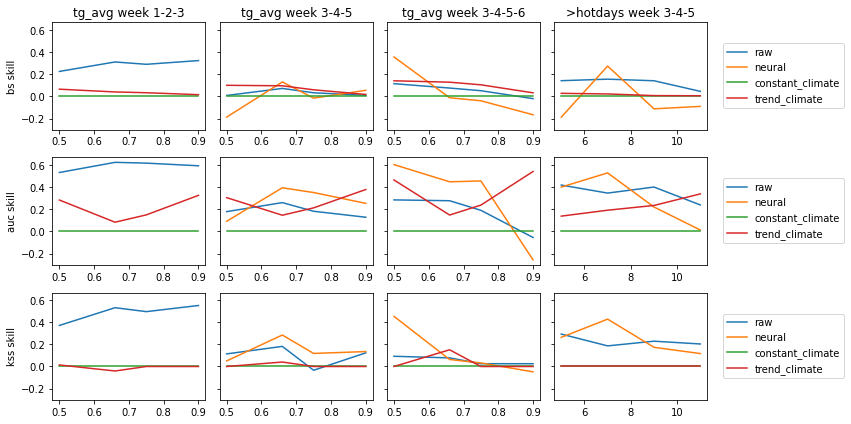

In [6]:
fig, axes = plt.subplots(nrows=3, ncols = 4, figsize = (12,6), sharey = True, facecolor='white')
aliases = pd.Series(['raw','neural','constant_climate','trend_climate'], index = ['pi','ppsf','climatology','trend'])
def plotranks(ax, plotframe):
    plotframe = plotframe.copy()
    plotframe.columns = plotframe.columns.droplevel(0)
    if not ('ppsf' in plotframe.columns):
        plotframe['ppsf'] = np.nan
    for label in aliases.index:
        ax.plot(plotframe.index, plotframe[label], label = aliases.loc[label])
    return ax
for i,score in enumerate(rankraw.columns.get_level_values('score').unique()):

    plotranks(ax = axes[i,0], plotframe = rankraw.loc[:,(score,slice(None))]) # First raw tganom 21
    plotranks(ax = axes[i,1], plotframe = ranktganom.loc[21,(score,slice(None))]) # Then pp tganom 21
    plotranks(ax = axes[i,2], plotframe = ranktganom.loc[31,(score,slice(None))]) # Then pp tganom 31
    plotranks(ax = axes[i,3], plotframe = ranktgex.loc[:,(score,slice(None))]) # Then hotdays
    #axes[i,1].plot()
    #axes[i,2].plot(ranktganom.loc[31,(score,slice(None))]) 
    #axes[i,3].plot(ranktgex.loc[:,(score,slice(None))]) # Then hotdays
    axes[i,3].legend(loc = (1.1,0.2))
    axes[i,0].set_ylabel(f'{score} skill')

axes[0,0].set_title('tg_avg week 1-2-3')
axes[0,1].set_title('tg_avg week 3-4-5')
axes[0,2].set_title('tg_avg week 3-4-5-6')
axes[0,3].set_title('>hotdays week 3-4-5')
plt.tight_layout()

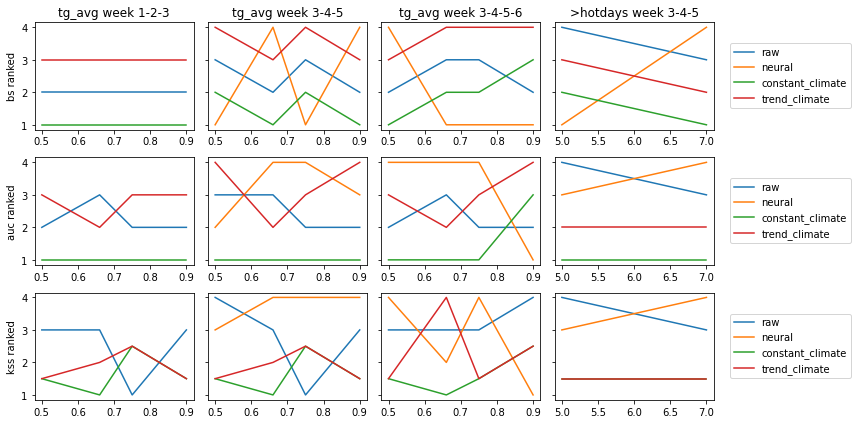

In [35]:
fig, axes = plt.subplots(nrows=3, ncols = 4, figsize = (12,6), sharey = True, facecolor='white')
aliases = pd.Series(['raw','neural','constant_climate','trend_climate'], index = ['pi','ppsf','climatology','trend'])
def plotranks(ax, plotframe):
    plotframe = plotframe.copy()
    plotframe.columns = plotframe.columns.droplevel(0)
    if not ('ppsf' in plotframe.columns):
        plotframe['ppsf'] = np.nan
    for label in aliases.index:
        ax.plot(plotframe.index, plotframe[label], label = aliases.loc[label])
    return ax
for i,score in enumerate(rankraw.columns.get_level_values('score').unique()):

    plotranks(ax = axes[i,0], plotframe = rankraw.loc[:,(score,slice(None))]) # First raw tganom 21
    plotranks(ax = axes[i,1], plotframe = ranktganom.loc[21,(score,slice(None))]) # Then pp tganom 21
    plotranks(ax = axes[i,2], plotframe = ranktganom.loc[31,(score,slice(None))]) # Then pp tganom 31
    plotranks(ax = axes[i,3], plotframe = ranktgex.loc[:,(score,slice(None))]) # Then hotdays
    #axes[i,1].plot()
    #axes[i,2].plot(ranktganom.loc[31,(score,slice(None))]) 
    #axes[i,3].plot(ranktgex.loc[:,(score,slice(None))]) # Then hotdays
    axes[i,3].legend(loc = (1.1,0.2))
    axes[i,0].set_ylabel(f'{score} ranked')

axes[0,0].set_title('tg_avg week 1-2-3')
axes[0,1].set_title('tg_avg week 3-4-5')
axes[0,2].set_title('tg_avg week 3-4-5-6')
axes[0,3].set_title('>hotdays week 3-4-5')
plt.tight_layout()